In [1]:
!pip install -Uqq dicomsdl fastai 

In [2]:
from fastai.basics import *
from fastai.medical.imaging import *

import numpy as np
import pandas as pd
import cv2
import dicomsdl as dicom
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
class CreateDicomDf():
    
    def __init__(self, path: str):
        self.path = Path(path)
        self.items = get_dicom_files(self.path)
        
    def get_sample_names(self, n=5):
        return self.items[:n].attrgot("name")
    
    def show_example(self):
        idx = np.random.randint(0, len(self.items))
        sample = self.items[idx].dcmread()
        return sample, sample.show()
    
    def create_dicom_df(self, name: str, px_summ=False):
        df = pd.DataFrame.from_dicoms(self.items, px_summ=px_summ)
        df.to_csv(f"{name}.csv")
        return df
    
    def __len__(self):
        return len(self.items)

In [4]:
class MammoPreprocessorBase:
    def __init__(
        self,
        img_path: str,
        image_size: tuple = (4096, 2048),
        dir_name: str = "Mammography_Dataset",
    ):
        """
        Initializes the object with the path to the images and desired image size.
        Creates a directory to save preprocessed images if it doesn't exist.
        """
        self.img_path = img_path
        self.image_size = image_size
        if dir_name:
            os.makedirs(f"{dir_name}", exist_ok=True)
            self.save_path = os.path.join(os.getcwd(), dir_name)
        self.images = glob(f"{img_path}/**/*.dcm", recursive=True)

    def preprocess_all(
        self, fformat: str, hist_eq_type: str = "hist_eq", n_jobs: int = -1, save=True
    ):
        """
        Preprocesses all images in parallel.
        Applies histogram equalization if hist_eq_type=True, saves images if save=True.
        """
        Parallel(n_jobs=n_jobs)(
            delayed(self.preprocess_image)(path, fformat, hist_eq_type, save)
            for path in tqdm(self.images, total=len(self.images))
        )
        print("Parallel preprocessing done!")

    def _hist_eq(self, img, hist_eq_type="hist_eq"):
        # Histogram equalization only works on 8-bit images
        img = self._convert_to_8bit(img)

        if hist_eq_type == "hist_eq":
            return cv2.equalizeHist(img)

        if hist_eq_type == "clahe":
            clahe_create = cv2.createCLAHE(clipLimit=2.0)
            return clahe_create.apply(img)
        
        if hist_eq_type == "combined":
            clahe_create = cv2.createCLAHE(clipLimit=2.0)
            clahe_img = clahe_create.apply(img)
            hist_eq_img = cv2.equalizeHist(img)
            return np.dstack([img, hist_eq_img, clahe_img])

    def _convert_to_8bit(self, img):
        return (img / img.max() * 255).astype(np.uint8)

    def _padresize_to_width(self, img, size, mask=None):
        h, w = img.shape

        # If the width of the image is less than the desired width
        if w < size[1]:
            # Add padding to the right side of the image to reach the desired width
            img = cv2.copyMakeBorder(
                img, 0, 0, 0, size[1] - w, cv2.BORDER_CONSTANT, value=(0, 0, 0)
            )
            if mask is not None:
                mask = cv2.copyMakeBorder(
                    mask, 0, 0, 0, size[1] - w, cv2.BORDER_CONSTANT, value=(0, 0, 0)
                )

        # If the width of the image is greater than the desired width
        if w > size[1]:
            # Resize the image to the desired width
            img = cv2.resize(img, (size[1], size[0]))
            # Resize the mask if provided with interpolation set to nearest to keep pixel values
            if mask is not None:
                mask = cv2.resize(
                    mask, (size[1], size[0]), interpolation=cv2.INTER_NEAREST
                )

        return (img, mask) if mask is not None else img

    # Resize image but keep aspect ratio
    def _resize_to_height(self, img, size, mask=None):
        h, w = img.shape
        # Calculate aspect ratio
        r = h / w
        # Resize to desired height and calculate width to keep aspect ratio
        new_size = (int(size[0] / r), size[0])

        # cv2.resize takes image size in form (width, height)
        img = cv2.resize(img, new_size)
        if mask is not None:
            # Use nearest interpolation to keep mask pixel values
            mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)

        return (img, mask) if mask is not None else img

    def _crop_roi(self, img, mask=None):
        # Binarize image to remove background noise
        bin_img = self._binarize(img)
        # Find the largest contour
        contour = self._find_contours(bin_img)

        # Create a bounding box from the contour
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])

        # Use bounding box coordinates to crop the image and mask if provided
        return (
            (img[y1:y2, x1:x2], mask[y1:y2, x1:x2])
            if mask is not None
            else img[y1:y2, x1:x2]
        )

    def _remove_background(self, img, remove_wlines=True):

        # Binarize image to remove noise and find the largest contour
        bin_img = self._binarize(img)
        contour = self._find_contours(bin_img)

        # Create a mask from the contour
        mask = np.zeros(bin_img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)

        # Multiply the image with the black and white
        return img * mask

    def _find_contours(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
        )
        # Select the largest contour
        contour = max(contours, key=cv2.contourArea)

        return contour

    def _binarize(self, img):
        # Binarize the image with a 5% threshold
        binarized = (img > (img.max() * 0.05)).astype("uint8")

        return binarized

    def _correct_side(self, img, mask=None):
        # Split image symetrically
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        # Sum the pixel values on each side
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])

        # Determine where the breast is by comparing total pixel values
        if left_col_sum > right_col_sum:
            return (img, mask) if mask is not None else img
        # Flip if breast on the right
        else:
            return (
                (np.fliplr(img), np.fliplr(mask))
                if mask is not None
                else np.fliplr(img)
            )

In [5]:
# Class for preprocessing mammography images from CBIS-DDSM
# Inherits most methods from base class
class MammoPreprocessorCBISDDSM(MammoPreprocessorBase):
    def __init__(
        self,
        img_path: str,
        mask_path: str = None,
        mammo_imgs_csv: str = None,
        masks_csv: str = None,
        case_desc_csv: str = None,
        image_size: tuple = (4096, 2048),
        dir_name: str = "CBIS_DDSM",
    ):
        super().__init__(img_path, image_size, dir_name)

        assert case_desc_csv is not None, "Please provide case description csv from the dataset"
        if masks_csv is None:
            masks_csv = CreateDicomDf(mask_path).create_dicom_df(name="masks_csv")
        if mammo_imgs_csv is None:
            mammo_imgs_csv = CreateDicomDf(img_path).create_dicom_df(name="mammo_imgs_csv")

        # Cleaning and merging the datasets that came with the images
        self.df = self._merge_dfs(mammo_imgs_csv, masks_csv, case_desc_csv)

    def preprocess_image(
        self, path: str, fformat: str = "png", hist_eq_type: str = "hist_eq", save: bool = True
    ):
        # Use dicomsdl to open dcm files (faster than pydicom)
        img = dicom.open(path).pixelData()
        # Each abnormality has a seperate mask so combine then into one for each image
        labels = self._combine_masks(path)

        img, labels = self._remove_wlines(img, labels)
        img, labels = super()._correct_side(img, labels)
        img = super()._remove_background(img)
        img, labels = super()._crop_roi(img, labels)
        img, labels = super()._resize_to_height(img, self.image_size, labels)
        img, labels = super()._padresize_to_width(img, self.image_size, labels)
        if hist_eq_type is not None:
            img = super()._hist_eq(img, hist_eq_type)
        else:
            img = super()._convert_to_8bit(img)

        if save:
            self._save_image(img, path, fformat=fformat, mask=labels)
        else:
            return img, labels

    def _save_image(self, img, path, fformat: str, mask=None):
        """
        Naming convention:
        Mass-Training_P_00001_LEFT_MLO_mammo.png

        Lesion type/train or test/patient id/left or right breast/view/mask or image/exstension
        """

        dir_path = self._create_save_path(path)
        fname = re.search("/.+/(.+_P_[0-9]+_.+?)/", path).group(1)

        fname_img = f"{fname}_FULL.{fformat}"
        save_path = os.path.join(dir_path, fname_img)
        cv2.imwrite(save_path, img)

        if mask is not None:
            fname_mask = f"{fname}_MASK.png"
            save_path = os.path.join(dir_path, fname_mask)
            cv2.imwrite(save_path, mask)

    #https://towardsdatascience.com/can-you-find-the-breast-tumours-part-2-of-3-1d43840707fc
    def _remove_wlines(self, img, mask=None, l=0.01, r=0.01, u=0.04, d=0.04):
        nrows, ncols = img.shape

        # Get the start and end rows and columns
        l_crop = int(ncols * l)
        r_crop = int(ncols * (1 - r))
        u_crop = int(nrows * u)
        d_crop = int(nrows * (1 - d))

        return (img[u_crop:d_crop, l_crop:r_crop], mask[u_crop:d_crop, l_crop:r_crop]) if mask is not None else img[u_crop:d_crop, l_crop:r_crop]
    
    def _create_save_path(self, img_path):
        # Create a folder from patient id
        patient_folder = re.search("_(P_[0-9]+)_", img_path).group(1)

        save_path = os.path.join(self.save_path, patient_folder)
        os.makedirs(save_path, exist_ok=True)

        return save_path

    def _combine_masks(self, path):
        
        path = Path(path)
        
        image_info = self.df.loc[self.df.full_img_fname == str(path)]
        if image_info.empty:
            raise ValueError

        labels = 0
        for i in range(image_info.shape[0]):
            mask = image_info.iloc[i]
            mask_px = (dicom.open(mask.mask_fname).pixelData() / 255).astype(np.uint8)
            # Mask are coded: 1 for benign, 2 for malignant
            labels = np.maximum(labels, mask_px * mask.pathology)

        return labels

    def _merge_dfs(self, df_full, df_mask, case_desc_csv):
        
        if isinstance(df_full, str):
            df_full = pd.read_csv(df_full)
        if isinstance(df_mask, str):
            df_mask = pd.read_csv(df_mask)
        df_mass = pd.read_csv(case_desc_csv)

        mass_type = df_full["PatientID"].str.split("_", n=1)[0][0]
        df_mass["PatientID"] = (
            mass_type
            + "_"
            + df_mass.patient_id
            + "_"
            + df_mass["left or right breast"]
            + "_"
            + df_mass["image view"]
            + "_"
            + df_mass["abnormality id"].astype("str")
        )
        df_mask = df_mask.loc[
            df_mask.SeriesDescription == "ROI mask images",
        ].reset_index(drop=True)

        mass_cols_keep = ["PatientID", "pathology"]
        mask_cols_keep = ["PatientID", "fname"]
        full_cols_keep = ["PatientID", "fname"]

        df_mass = df_mass[mass_cols_keep]
        df_mask = df_mask[mask_cols_keep]
        df_full = df_full[full_cols_keep]

        df_mass = df_mass.rename(columns={"PatientID": "PathologyID"})
        df_mask = df_mask.rename(
            columns={"PatientID": "PathologyID", "fname": "mask_fname"})
        df_full = df_full.rename(
            columns={"PatientID": "ImageID", "fname": "full_img_fname"})

        df_all = df_mass.merge(df_mask, on="PathologyID")
        df_all["ImageID"] = df_all.PathologyID.str.replace(r"_[0-9]$", "", regex=True)
        df_all = df_all.merge(df_full, on="ImageID", how="left")

        df_all["PatientID"] = df_all.PathologyID.str.extract(
            "(P_[0-9]+)_", expand=False
        )
        df_all["pathology"] = df_all.pathology.str.replace("_.*", "", regex=True)
        df_all["pathology"] = df_all["pathology"].replace({"BENIGN": 1, "MALIGNANT": 2})

        df_all.sort_values(by="PatientID", ignore_index=True, inplace=True)

        return df_all


In [6]:
img_path = "/kaggle/input/masstraining-full-mammogram-images/CBIS-DDSM"
masks = "/kaggle/input/masstraining-roimask-and-crpped-images/CBIS-DDSM"
case_desc_csv = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv"

In [7]:
%%time
dst = MammoPreprocessorCBISDDSM(img_path, masks, 
                                case_desc_csv=case_desc_csv, 
                                image_size=(512,512),
                                dir_name="./data/train/processed_512x_alleq/")

CPU times: user 27 s, sys: 26.2 s, total: 53.2 s
Wall time: 2min 50s


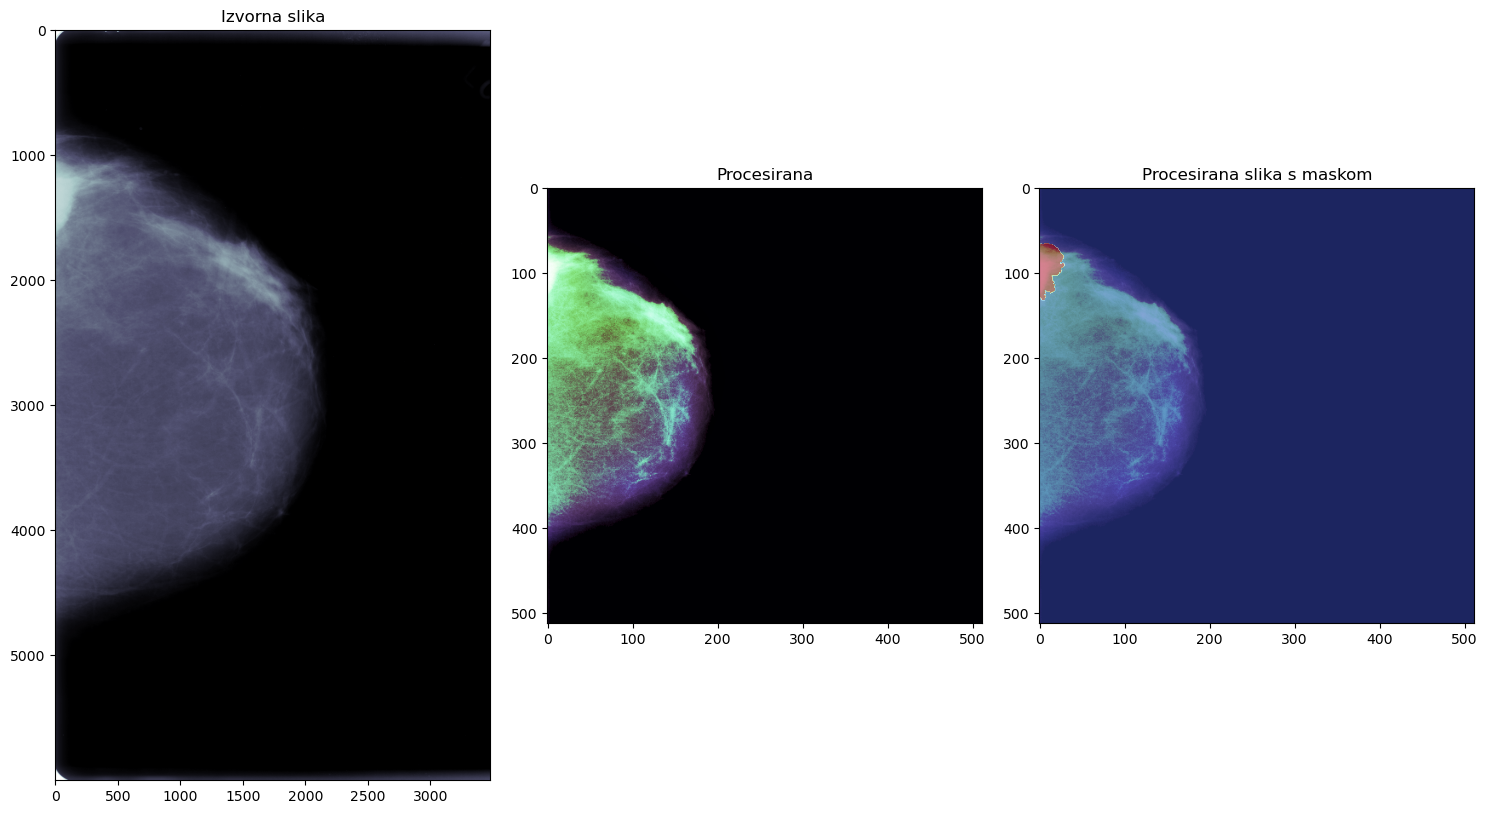

In [8]:
i = np.random.randint(0, len(dst.images))
example = dst.images[i]

raw_img = dicom.open(example).pixelData()
processed_img, processed_mask = dst.preprocess_image(example, save=False, hist_eq_type="combined")

_, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))

axs[0].imshow(raw_img, cmap="bone")
axs[0].set_title("Izvorna slika")

axs[1].imshow(processed_img, cmap="bone")
axs[1].set_title("Procesirana")

axs[2].imshow(processed_img, cmap="bone")
axs[2].imshow(processed_mask, alpha=0.50, cmap="coolwarm")
axs[2].set_title("Procesirana slika s maskom")

plt.tight_layout();

In [9]:
dst.preprocess_all(fformat="png", hist_eq_type = "combined", n_jobs = -1, save=True)

  0%|          | 0/1231 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Parallel preprocessing done!


In [10]:
######TEST SET

In [11]:
img_path = "/kaggle/input/mass-test-full-mammogram-images-dicom/manifest-KlyiOp8o8257600061251652132/CBIS-DDSM"
masks = "/kaggle/input/mass-test-roi-and-cropped-images-dicom/manifest-OlX3eVq41551709337535597984/CBIS-DDSM"
case_desc_csv = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv"

In [12]:
%%time
dst = MammoPreprocessorCBISDDSM(img_path, masks,
                                case_desc_csv=case_desc_csv, 
                                image_size=(512,512),
                                dir_name="./data/test/processed_512x_alleq/")

CPU times: user 8.42 s, sys: 7.99 s, total: 16.4 s
Wall time: 1min 13s


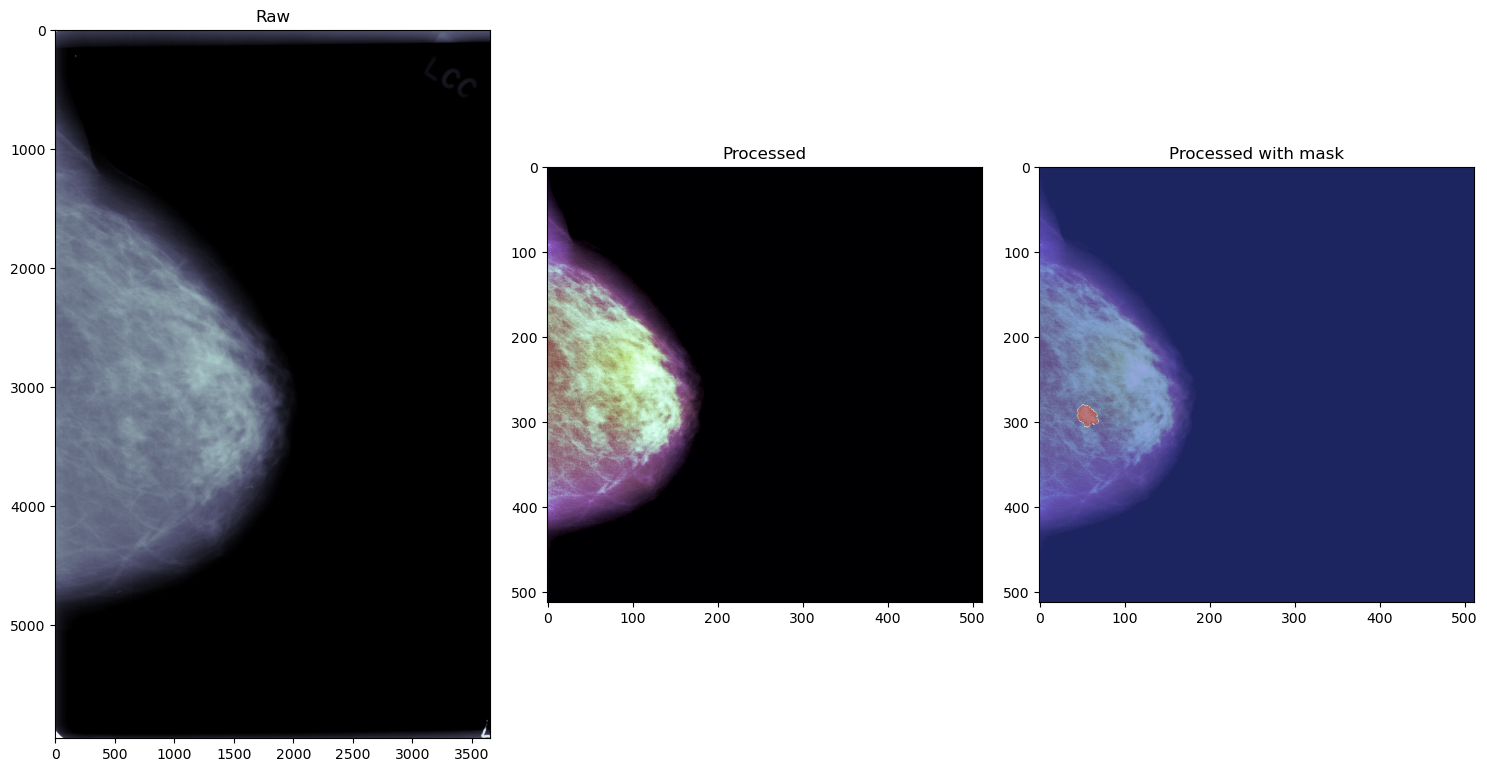

In [13]:
i = np.random.randint(0, len(dst.images))
example = dst.images[i]

raw_img = dicom.open(example).pixelData()
processed_img, processed_mask = dst.preprocess_image(example, save=False, hist_eq_type="combined")


_, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))

axs[0].imshow(raw_img, cmap="bone")
axs[0].set_title("Raw")

axs[1].imshow(processed_img, cmap="bone")
axs[1].set_title("Processed")

axs[2].imshow(processed_img, cmap="bone")
axs[2].imshow(processed_mask, alpha=0.50, cmap="coolwarm")
axs[2].set_title("Processed with mask")

plt.tight_layout();

In [14]:
dst.preprocess_all(fformat="png", hist_eq_type = "combined", n_jobs = -1, save=True)

  0%|          | 0/361 [00:00<?, ?it/s]

Parallel preprocessing done!
